<a href="https://colab.research.google.com/github/mavivi95/Notebooks/blob/main/EDCO2_laboratorio_LSTM_Reto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>

<br>
<center>  <strong> <font face="Courier New" size=6 color='#EDF01C'> Desafío Redes Neuronales Recurrentes: LSTM</font> </strong> </center>

<br>
<center>
 <p>
 Manuela Viviana Chacón Chamorro </p>
</center>

---

# 1. Introducción y contexto

En este laboratorio te enfrentarás al desafío de predecir la Radiación Solar Global Horizontal (GHI) para dos días futuros en una serie temporal con ventanas de una semana. El enfoque principal consiste en explorar y aplicar Redes Neuronales Recurrentes (RNN), específicamente la arquitectura Long Short-Term Memory (LSTM), para llevar a cabo esta tarea de predicción. Durante el desarrollo del laboratorio, se realizará la carga de datos, el acondicionamiento necesario y encontrarás celdas de código base que podrás modificar para mejorar el rendimiento del modelo y cumplir con un umbral de error establecido.

# 2. Importar y acondicionar datos

In [ ]:
# Celda con la importación de librerias

import pandas as pd               # Librería para manejo de dataframes
import numpy as np                # Librería para trabajar don datos matriciales
import matplotlib.pyplot as plt   # Librería de visualización


# TensorFlow
import tensorflow as tf                                                # Importar TensorFlow
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed    # Importar las capas densas y LSTM
from keras.models import Sequential         # Importar modelo de clase secuencial
from keras.callbacks import EarlyStopping   # Importar clase de parada temparana

# Sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score   # Importar métricas de validación
from sklearn.preprocessing import StandardScaler      # Importar objeto para realizar estandarización de variables


from time import time   # Librería para cálculos de tiempos de ejecución


np.random.seed(42) # Inicializar semilla para numeros aleatorios

In [ ]:
# Se lee el archivo de datos y se convierte en un DataFrame,
# una estructura especial que representa los datos en forma de tabla,
# facilitando su manipulación y análisis.

GHI = pd.read_csv('GHI_sa.csv')
GHI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175200 entries, 0 to 175199
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       175200 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


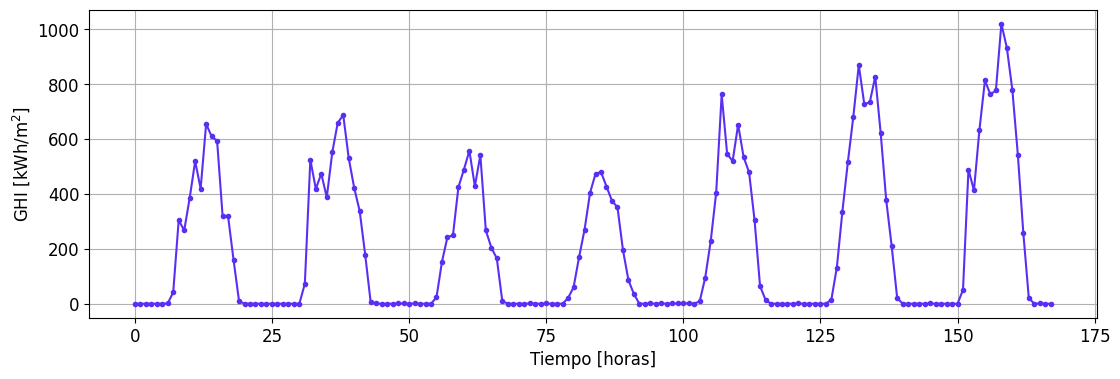

In [ ]:
# Una ventana de observación de una semana
# se utiliza para visualizar las señales de GHI.

plt.figure(figsize = (13, 4))
plt.plot(GHI[0:24*7],'#5a2ff4', marker = ".", linewidth= 1.5)
plt.xlabel("Tiempo [horas]", fontsize=12)
plt.xticks(size=12)
plt.ylabel("GHI [kWh/m$^2$]", fontsize=12)
plt.yticks(size=12)
plt.grid()
plt.show()

A continuación, realizamos dos pasos importantes en la preparación de datos para un modelo de predicción de series temporales. Primero, llevamos a cabo la estandarización de la variable de interés, en este caso, la GHI. Luego, procedemos a dividir los datos temporalmente, asignando un año para entrenamiento, otro para pruebas y un tercero para validación. La estandarización es un proceso fundamental que asegura que todas las observaciones compartan una escala común, lo cual es esencial para el buen rendimiento de muchos algoritmos de aprendizaje automático. Aquí, la función StandardScaler transforma los valores de GHI, ajustando la media a cero y la desviación estándar a uno. La segunda parte se encarga de dividir la serie temporal estandarizada en tres conjuntos distintos. El primer año se asigna para entrenamiento (X_train), el segundo para validación (X_val), y el tercer año para pruebas (X_test). Esta división es necesaria para evaluar la capacidad predictiva del modelo en datos no vistos, garantizando una evaluación justa de su rendimiento.

In [ ]:
# Estandarización
X = np.array(GHI)       # Arrego de secuencia
scaler = StandardScaler().fit(X.reshape(-1, 1)) # Estandarización de la secuencia
X = scaler.transform(X.reshape(-1, 1)) # Tranformar los datos de la secuencia
X = X.ravel() # Adaptar las dimensiones del arreglo X

# División en conjunto de entrenamiento, validación y prueba
n = 365*24            # Número de horas en un año
X_train = X[:n]       # Separación 1 año de entrenamiento
X_val = X[n:2*n]      # Separación 2 año para validación
X_test = X[2*n:3*n]   # Separación 3 año para prueba

In [ ]:
# Imprimimos las dimensiones de los conjuntos
print(f"Dimensión del conjunto general de observaciones {X.shape}")
print(f"Dimensión del conjunto de entrenamiento {X_train.shape}")
print(f"Dimensión del conjunto de validación {X_val.shape}")
print(f"Dimensión del conjunto de prueba {X_test.shape}")

Dimensión del conjunto general de observaciones (175200,)
Dimensión del conjunto de entrenamiento (8760,)
Dimensión del conjunto de validación (8760,)
Dimensión del conjunto de prueba (8760,)


En esta celda de código, presentamos la función `split_sequence`, diseñada para realizar la división de secuencias temporales. La función tiene como objetivo preparar los datos para entrenar modelos predictivos, dividiendo una secuencia temporal en fragmentos más pequeños. Esto facilita al modelo aprender patrones a partir de un histórico distribuido en ventanas de tiempo. Esta función se empleará más adelante para separar los datos de acuerdo con las ventanas sobre las que se desee generar predicciones.

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  """
  Función que realiza la división de una secuencia temporal en conjuntos de entrada y salida.

  Parámetros:
  - sequence: Secuencia temporal (iterable, como una lista) de observaciones.
  - n_steps_in: Número de observaciones utilizadas en cada ventana de datos de entrada.
  - n_steps_out: Número de observaciones utilizadas en cada ventana de etiquetas secuenciales.

  Salida:
  - np.array(X): Ventanas de tiempo con datos temporales utilizadas como entrada.
  - np.array(y): Ventanas de tiempo con datos temporales utilizadas como etiquetas secuenciales.
  """

  X, y = list(), list()               # Prepara una lista de X, y
  for i in range(len(sequence)):      # Ciclo iterable en todos los elementos de la secuencia temporal
      end_ix = i + n_steps_in         # Cálculo de indices finales de la ventana de observación X
      out_end_ix = end_ix + n_steps_out   # Cálculo de indices finales de la ventana de observación Y
      if out_end_ix > len(sequence): break # Salir del ciclo si el indice final de ventana Y supera la longitud de la secuencia

      # Segmentar vectores y guardar en X, y
      X.append(sequence[i:end_ix])
      y.append(sequence[end_ix:out_end_ix])

  return np.array(X), np.array(y)

# 3. Forecasting con redes LSTM

En el contexto de nuestro estudio, el *forecasting* implica la utilización de datos históricos para anticipar la GHI. En particular, el desafio es predecir la GHI para los dos días inmediatamente posteriores después de analizar una semana completa de datos. Inicialmente usando la función de división de ventanas se construyen los conjuntos de datos y etiquetas, luego se genera el modelo de RNN para realizar la predicción y finalmente con los conjuntos de prueba y validación se realiza la evaluación del modelo.

## 3.1 División en ventanas de tiempo

En esta sección se realiza la división de los datos configurando la ventana de observación y predicción. En este caso la ventana de observación será una semana y en predicción dos dias siguientes.

In [ ]:
# Elegir número de pasos de entrada y salida
n_steps_in_d = 168      # 7 días previos 7*24
n_steps_out_d = 48      # predecir dos días 2*24

# Dividir en muestras utilizando la función split_sequence
# Datos de entrenamiento
X_t, y_t = split_sequence(X_train, n_steps_in_d, n_steps_out_d)
# Datos de validación
X_v, y_v = split_sequence(X_val, n_steps_in_d, n_steps_out_d)

# Imprimir las dimensiones de los conjuntos segemnetados en ventanas
print(f"Dimensions de datos de observaciones entrenamiento {X_t.shape}")
print(f"Dimensions de datos de predicciones entrenamiento {y_t.shape}")
print(f"Dimensions de datos de observaciones validación {X_v.shape}")
print(f"Dimensions de datos de predicciones validación {y_v.shape}")

Dimensions de datos de observaciones entrenamiento (8545, 168)
Dimensions de datos de predicciones entrenamiento (8545, 48)
Dimensions de datos de observaciones validación (8545, 168)
Dimensions de datos de predicciones validación (8545, 48)


Como ejemplo visualizaremos de manera una ventana temporal específica junto con su correspondiente etiqueta de predicción.

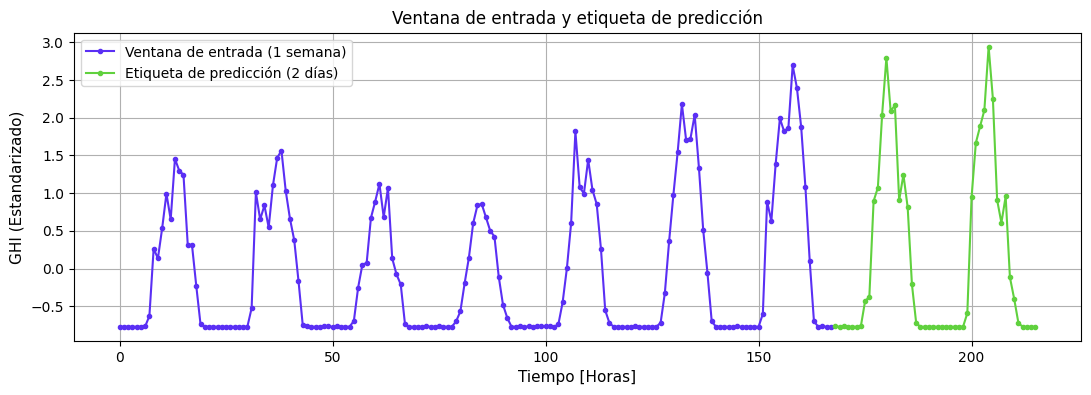

In [ ]:
# Tomar una muestra de entrenamiento para la visualización
sample_index = 0  # Indice de la ventana
sample_X, sample_y = X_t[sample_index], y_t[sample_index]

# Crear una figura
plt.figure(figsize=(13, 4))

# Visualizar la ventana de entrada y la etiqueta de predicción
plt.plot(np.arange(len(sample_X)), sample_X, label='Ventana de entrada (1 semana)',
        color = '#5a2ff4', marker = ".", lw= 1.5)
plt.plot(np.arange(len(sample_X), len(sample_X) + len(sample_y)), sample_y, label='Etiqueta de predicción (2 días)',
         color='#60d13e', marker = ".", lw = 1.5)

# Ajustar detalles de la gráfica
plt.title('Ventana de entrada y etiqueta de predicción')
plt.xlabel('Tiempo [Horas]', fontsize=11)
plt.ylabel('GHI (Estandarizado)', fontsize=11)
plt.legend()
plt.grid()

# Mostrar la figura
plt.show()

Antes de continuar con la construcción del modelo LSTM, los datos deben ser acondicionados en el número de caracteristicas. La redimensión de las muestras temporales, originalmente en el formato [muestras, timesteps], se lleva a cabo para incluir una dimensión adicional que representa las características de cada punto temporal. Este ajuste estructural, de [muestras, timesteps] a [muestras, timesteps, características], es esencial para adecuar los datos al formato requerido por muchos modelos de redes neuronales, donde cada paso temporal puede tener múltiples características asociadas. En nuestro caso solamente se tiene una carácteristica, pero el modelo tambíen podría considerar otras variables.

In [ ]:
# Redimensionar [muestras, timesteps] a [muestras, timesteps, características]
n_features = 1 # En este caso solo se tiene una característica en cada observación temporal
# Redimensionamiento
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features)) # Ventana de entrada en entrenamiento
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features)) # Ventana de etiquetas en entrenamiento
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features)) # Ventana de entrada en validación
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features)) # Ventana de etiquetas en validación

# Imprimir las dimensiones de los conjuntos redimensionados
print(f"Dimensions de datos de observaciones entrenamiento {X_t.shape}")
print(f"Dimensions de datos de predicciones entrenamiento {y_t.shape}")
print(f"Dimensions de datos de observaciones validación {X_v.shape}")
print(f"Dimensions de datos de predicciones validación {y_v.shape}")

Dimensions de datos de observaciones entrenamiento (8545, 168, 1)
Dimensions de datos de predicciones entrenamiento (8545, 48, 1)
Dimensions de datos de observaciones validación (8545, 168, 1)
Dimensions de datos de predicciones validación (8545, 48, 1)


## 3.2 Modelo LSTM

En esta sección, establecemos la arquitectura de nuestro modelo de *forecasting* utilizando una red neuronal recurrente RNN. El diseño consta de un *encoder* seguido por un *decoder*, implementando la arquitectura LSTM (Long Short-Term Memory) para capturar patrones temporales. Con la actual arquitectura, el modelo está operativo, aunque su rendimiento es considerablemente bajo. Entonces, tienes la libertad de ajustar estas celdas según tus conocimientos. Puedes considerar aumentar el número de unidades neuronales en la capa LSTM, incrementar el número de épocas de entrenamiento, cambiar el optimizador, o experimentar con combinaciones de estos ajustes. No dudes en editar las celdas según tu criterio.

El objetivo es lograr que el modelo modelo tenga un **error cuadrático medio (rmse) inferior a 130** para la primera ventana en el conjunto de prueba.

In [ ]:
# Modelo LSTM para predicción
# puedes modificar esta celda según consideres

model = Sequential()      # Tipo de modelo secuencial

# Encoder
model.add(LSTM(4, input_shape=(n_steps_in_d, n_features))) # Capa LSTM preparada para recibir n_steps_in_d
model.add(RepeatVector(n_steps_out_d)) # Repite el vector de salida tantas veces como indique n_steps_out_d

# Decoder
model.add(LSTM(4, return_sequences=True)) # Capa LSTM y configurada para devolver secuencias completas
model.add(TimeDistributed(Dense(1)))    # Permite que la capa densa sea aplicada a cada paso temporal de la secuencia por separado.

In [ ]:
# Resumen de la arquitectural del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 repeat_vector (RepeatVecto  (None, 48, 4)             0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 48, 4)             144       
                                                                 
 time_distributed (TimeDist  (None, 48, 1)             5         
 ributed)                                                        
                                                                 
Total params: 245 (980.00 Byte)
Trainable params: 245 (980.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compilación del modelo
# puedes modificar esta celda según consideres
model.compile(optimizer='SGD', loss='mse')

En esta etapa, procedemos con el entrenamiento del modelo de forecasting diario utilizando los conjuntos de datos de entrenamiento y validación. Para el entrenamiento se configuró una estrategia de parada anticipada (`EarlyStopping`) con el objetivo de prevenir el sobreajuste del modelo. Esta estrategia detendrá el entrenamiento si la métrica de validación no mejora después de un cierto número de épocas y restaurará los pesos del modelo a los mejores obtenidos.

In [ ]:
# Entrenamiento del modelo
start = time()        # Se fija el tiempo incial en el que esta iniciando el entrenamiento

# Configuración parada temprana, se detiene si no mejora despues de 10 épocas
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Entrenamiento del modelo, puedes modificar etos parámetros según consideres
history = model.fit(X_t, y_t, epochs= 20, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])

print("El modelo tardó %.2f segundos en entrenar."% (time() - start)) # Tiempo total del entrenamiento

Epoch 1/20
67/67 [==============================] - 10s 44ms/step - loss: 1.0380 - val_loss: 1.0397
Epoch 2/20
67/67 [==============================] - 2s 28ms/step - loss: 1.0358 - val_loss: 1.0381
Epoch 3/20
67/67 [==============================] - 2s 28ms/step - loss: 1.0347 - val_loss: 1.0374
Epoch 4/20
67/67 [==============================] - 2s 26ms/step - loss: 1.0340 - val_loss: 1.0369
Epoch 5/20
67/67 [==============================] - 2s 31ms/step - loss: 1.0336 - val_loss: 1.0366
Epoch 6/20
67/67 [==============================] - 2s 30ms/step - loss: 1.0333 - val_loss: 1.0364
Epoch 7/20
67/67 [==============================] - 2s 27ms/step - loss: 1.0330 - val_loss: 1.0361
Epoch 8/20
67/67 [==============================] - 2s 25ms/step - loss: 1.0327 - val_loss: 1.0358
Epoch 9/20
67/67 [==============================] - 1s 22ms/step - loss: 1.0325 - val_loss: 1.0357
Epoch 10/20
67/67 [==============================] - 2s 24ms/step - loss: 1.0322 - val_loss: 1.0354
Epoch 11

In [ ]:
def visualization_history(resultsFit):
  """
  Esta función grafica las curvas de pérdida a lo largo de las épocas de entrenamiento
  para el conjunto de prueba como el de validación.
  Parámetros:
  resultsFit = historial de entrenamiento de un modelo en keras
  Salida:
  Gráfica de la precisión en validación y prueba.
  """
  # Llamado al entrono de la gráfica y fijar tamaño de visualización
  fig, axes = plt.subplots(1, 1, figsize=(13, 4))

  # Graficar la pérdida de la historia en entrenamiento
  axes.plot(range(len(resultsFit.history['loss'])), resultsFit.history['loss'],
           '#5a2ff4', linestyle = "-", marker = ".",
           label='Pérdida entrenamiento', lw = 2)

  # Graficar la presición de la historia en validación
  axes.plot(range(len(resultsFit.history['val_loss'])), resultsFit.history['val_loss'],  '#60d13e',
           label='Pérdida validación', linestyle = '-', marker = '.', lw =2)

  # Títulos de los ejes
  axes.set_xlabel('Época',fontsize=12)
  axes.set_ylabel(r'Pérdida',fontsize=12)
  axes.grid()      # Activar la cuadricula
  axes.legend(fontsize=12,loc = 'upper right')   # Establecer la legenda


  plt.tight_layout() # Ajusta automáticamente el diseño de la figura
  plt.show()

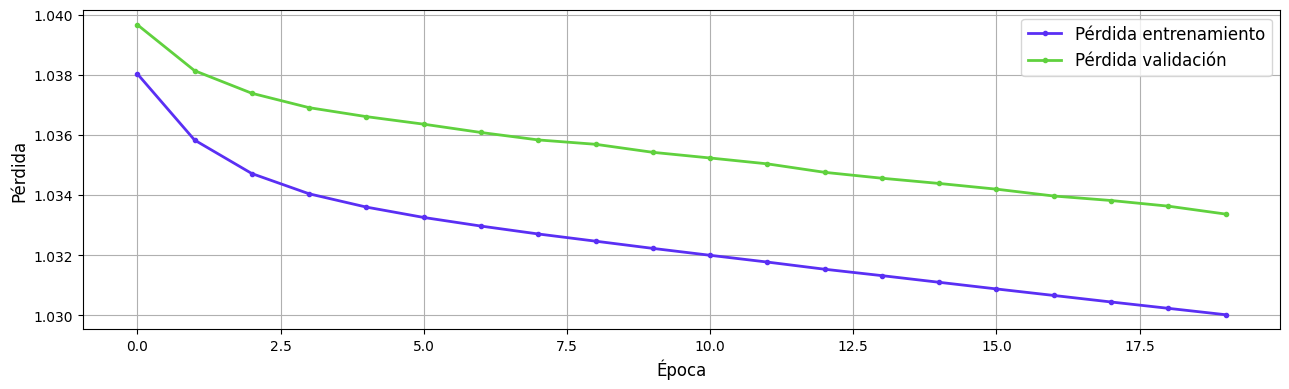

In [ ]:
# Llamado a la función de visualización de las métricas de la historia del entrenamiento
# del modelo.
visualization_history(history)

## 3.3. Evaluación del modelo

En esta sección, se cálcula para la primera ventana del conjunto de prueba las métricas del error cuadrático medio, el error absoluto y el coeficiente $R^2$.

In [ ]:
# División en ventanas del conjunto de prueba
X_test_, y_test_ = split_sequence(X_test, n_steps_in_d, n_steps_out_d)
# Transfromación inversa de los datos de predicción:
# Aplicamos una transformación inversa a las etiquetas de predicción (y_test)
# utilizando el objeto scaler. Este objeto se utilizó previamente para estandarizar los
# datos durante la preparación. Ahora se invierte para obtener las predicciones en la
# escala original de la GHI.
y_test = scaler.inverse_transform(y_test_)

In [ ]:
# Elegir un indice de ventana del conjunto de prueba, puede ser cualquier ventana
window_prediction = 0

# Preparación de la entrada para la predicción
x_input = X_test_[window_prediction].reshape((1, n_steps_in_d, n_features))

# Realización de la predicción y transformación inversa de los datos
yhat_normalized = model.predict(x_input)
yhat_unscaled = scaler.inverse_transform(yhat_normalized.reshape(-1, 1))

# Transformación inversa de los datos originales del conjunto de prueba
original_data_unscaled = scaler.inverse_transform(X_test_[window_prediction].reshape(-1, 1))

# Selección de datos para comparación: actual, predicción y datos previos
actual_data = y_test[0]
previous_data = np.hstack((original_data_unscaled.ravel(), actual_data))

1/1 [==============================] - 1s 767ms/step


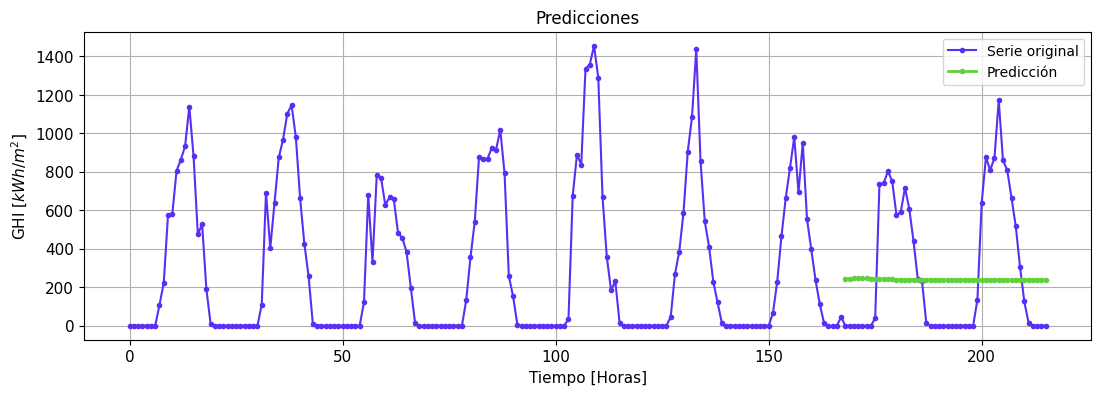

In [ ]:
# Dado que se grafican 7 días de datos y 2 de predicción se necesita una ventana de 9 días
windows_time = np.arange(24*9)

# Crear una figura
plt.figure(figsize=(13, 4))

# Visualizar la ventana de entrada y la etiqueta de predicción
plt.plot(previous_data, label='Serie original',
        color = '#5a2ff4', marker = ".", lw= 1.5)
plt.plot(windows_time[24*7:], yhat_unscaled, label='Predicción',
         color='#60d13e', marker = ".", lw = 2)

# Ajustar detalles de la gráfica
plt.title('Predicciones')
plt.xlabel('Tiempo [Horas]', fontsize=11)
plt.ylabel('GHI $[kWh/m^2]$', fontsize=11)
plt.yticks(size=11)
plt.xticks(size=11)
plt.legend()
plt.grid()

# Mostrar la figura
plt.show()

En la siguiente figura se grafica unicamente la predicción y los datos reales. Además se inlcuye una gráfica de barras para los errores absolutos cometidos en cada observación.

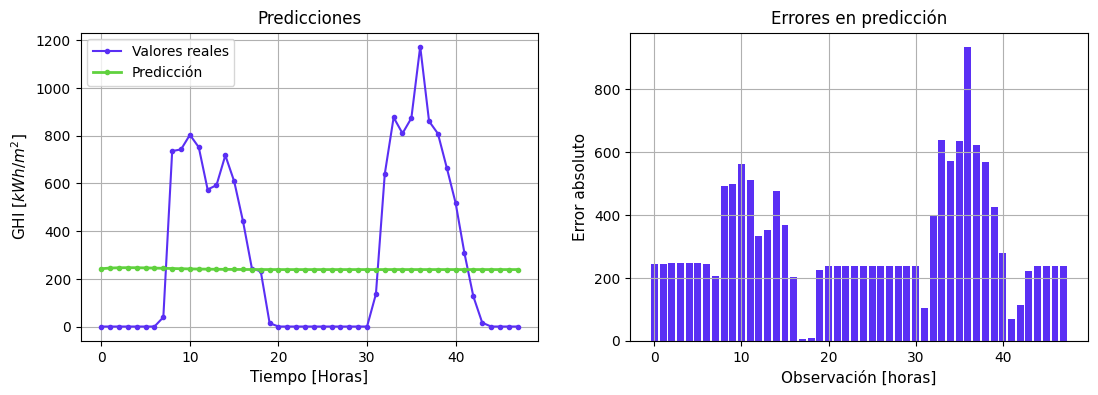

In [ ]:
# Crear una figura
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Visualizar la salida del modelo y la etiqueta de predicción
axes[0].plot(actual_data, label='Valores reales',
        color = '#5a2ff4', marker = ".", lw= 1.5)
axes[0].plot(yhat_unscaled, label='Predicción',
         color='#60d13e', marker = ".", lw = 2)

# Ajustar detalles de la gráfica
axes[0].set_title('Predicciones')
axes[0].set_xlabel('Tiempo [Horas]', fontsize=11)
axes[0].set_ylabel('GHI $[kWh/m^2]$', fontsize=11)
axes[0].legend()
axes[0].grid()


# Visualizar la salida del modelo y la etiqueta de predicción
axes[1].bar(range(48), np.abs(actual_data - yhat_unscaled.reshape(48,)),
            color = '#5a2ff4')

# Ajustar detalles de la gráfica
axes[1].set_title('Errores en predicción')
axes[1].set_xlabel('Observación [horas]', fontsize=11)
axes[1].set_ylabel('Error absoluto', fontsize=11)
axes[1].grid()

# Mostrar la figura
plt.show()

Ahora procedemos al cálculo de las métricas de evaluación para esta ventana en particular. En primer lugar, calculamos el error cuadrático medio y el error absoluto, que nos proporcionarán una medida de la precisión de nuestras predicciones, **asegurate este error cumpla con el umbral requerido en este taller**. Además, evaluamos el coeficiente de determinación, representado como $R^2$, el cual es una medida estadística que nos indica la proporción de la varianza en la variable dependiente que puede ser predicha por las variables independientes en un modelo de predicción. En líneas generales, cuanto más próximo a 1 sea el valor de $R^2$, mejor será el ajuste del modelo a los datos.

In [ ]:
rmse = np.sqrt(mean_squared_error(actual_data, yhat_unscaled))
mae = mean_absolute_error(actual_data, yhat_unscaled)
r2 = r2_score(actual_data, yhat_unscaled)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

Root mean square error:  361.97017060192616
Mean absolute error:  314.82318528493244
R-Squared:  -0.028726282005512527


Si lograste que el modelo modelo tenga un **error cuadrático medio (rmse) inferior a 130** para la primera ventana en el conjunto de prueba ¡Has completado el desafío!